In [1]:
from classo.solve_R2 import pathlasso_R2, Classo_R2, problem_R2
from classo.solve_R1 import pathlasso_R1, Classo_R1, problem_R1
from classo.solve_R3 import pathlasso_R3, Classo_R3, problem_R3
from classo.compact_func import Classo, pathlasso
from classo import random_data, classo_problem
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

m,d,d_nonzero,k,sigma =200,150,6,0,0.5
(X,C,y),sol = random_data(m,d,d_nonzero,k,sigma,zerosum=True,seed=None)

In [2]:
lam = 0.5
pb_dr = problem_R3((X,C,y),'DR')
pb_pa = problem_R3((X,C,y),'Path-Alg')

In [14]:
pb_dr.gam = m*d

In [15]:
beta_dr = Classo_R3(pb_dr,lam)[0]
beta_pa = Classo_R3(pb_pa,lam)[0]

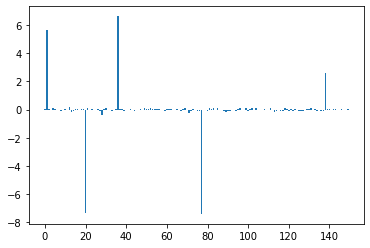

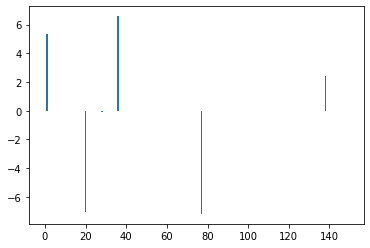

In [16]:
for beta in [beta_dr,beta_pa]:
    plt.bar(range(len(beta)),beta)
    plt.show()

In [ ]:
def R3(pb,lam):
    (m,d,k),(A,C,y)  = pb.dim,pb.matrix

    pb.compute_param()

    lamb          = lam * pb.lambdamax
    Anorm         = pb.Anorm
    tol           = pb.tol * LA.norm(y)/LA.norm(A)
    Proj          = proj_c(C,d)   # Proj = I - C^t . (C . C^t )^-1 . C
    
    c             = d**2/LA.norm(A)**2
    mu, root      = 1.95, 0.
    
    Q1,Q2         = QQ( c,A)
    QA            = Q1.dot(A)
    gamma         = c*d**2 * pb.gam / lam
    w,zerod       = lamb*gamma*np.ones(d), np.zeros(d)
    
    xs,nu,o,xbar,x= 1.,1.,np.zeros(m), np.zeros(d), np.zeros(d)    
    
    #2prox
    for i in range(pb.N):
        nv_b, nv_s = x + Q1.dot(o) - QA.dot(x) - Q2.dot(x-xbar), (xs+nu)/2
        if (i>0 and LA.norm(b-nv_b)+LA.norm(s-nv_s)/Anorm <2*tol):
            return(b,s)

        s,b = nv_s, nv_b
        Ab = A.dot(b)
        p1,p2,root = prox_phi_1(xs,2*Ab-o-y,gamma/c,root)
        sup = [ max(0,nu)-s , p1-s , p2 + y - Ab , prox(2*b-xbar,w,zerod)-b, Proj.dot(2*b-x)-b]
        xs,nu,o,xbar,x = xs+mu*sup[0] ,  nu+mu*sup[1] ,  o+mu*sup[2] ,  xbar+mu*sup[3] ,  x+mu*sup[4]

        if (LA.norm(b)+LA.norm(s)>1e6):
            raise ValueError("The algorithm of Doulgas Rachford diverges")

    raise ValueError("The algorithm of Doulgas Rachford did not converge after %i iterations " %pb.N)

In [22]:

# compute the prox of the function : f(b)= sum (wi * |bi| )
def prox(b,w,zeros): return(np.minimum(b+w,zeros)+np.maximum(b-w,zeros)) 

# Compute I - C^t (C.C^t)^-1 . C : the projection on Ker(C)
def proj_c(M,d):
    if (LA.matrix_rank(M)==0):  return(np.eye(d))
    return(np.eye(d)-LA.multi_dot([M.T,np.linalg.inv(M.dot(M.T) ),M]) )

# Compute the real positive root of a polynomial of degree 3 in the form : X^3 + a*X - b with Newton method and a warm start (for Comcomitant problem)
def calc_Newton(a,b,root):
    er = -b
    while (abs(er)>1e-6): 
        root= root-er/(3*root**2+a)
        er = root**3 + a*root-b
    return(root)

def QQ(coef,A): 
    # compute QQ = coef A^t (2.I.+coef A A^t )^-1 , (2.I.+coef A^t A)^-1 
    return(coef*(A.T).dot(LA.inv(2*np.eye(A.shape[0])+coef*A.dot(A.T))),LA.inv(2*np.eye(A.shape[1])+coef*(A.T).dot(A)))    

# Return the cost function of some Beta for a given Lasso problem : L_LS = ||y-Ab||2^2  + lambda* ||b||1
def L_LS(pb,lam,sol): return(LA.norm( pb.matrix[0].dot(sol) - pb.matrix[2] )**2 + lam*pb.lambdamax * LA.norm(sol,1))

# Return the prox operator for the function phi = ||(y-Ab)||2^2 /sigma + 1/2 * sigma with the warm start on the computation of the root    
def prox_phi_1(sig,u,gamma,warm_start):
    l2u = LA.norm(u)
    Po0 = 4*gamma*sig + l2u**2
    if (Po0 < 2*gamma**2): return(0.,0.,0.)
    else : 
        root=calc_Newton((4*sig/gamma+6.),8*l2u/gamma,warm_start)
        return(sig+0.5*gamma*(0.5*root**2-1.),u * (1-gamma*root/l2u),root)


    
# Return the positive root in [0,1] of the polynomial aX^2 + 2bX + c if it exists, 1. if not
def root_2(a,b,c):
    
    if (a==0.) : return(c/(2*b))
    root=   (-np.sqrt(b**2-a*c)-b)/a
    if (root > 1) : return(1.)
    return(root)

